In [1]:
%matplotlib inline

In [1]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                           _i1:  587.0 B
                           _oh:  240.0 B
                           Out:  240.0 B
                    sizeof_fmt:  136.0 B
                       __doc__:  113.0 B
                           _ih:   96.0 B
                            In:   96.0 B
                   __builtin__:   80.0 B
                  __builtins__:   80.0 B
                           sys:   80.0 B


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import CortexDataset, RetinaDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
import pickle
import scanpy as sc
import anndata
import torch

[2020-01-10 11:59:47,243] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [3]:
matrix = pickle.load(open('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.normalized.pkl','rb'))
latent = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.latent.csv.gz',index_col=0)
latent = latent.astype('float32')
latent.head()

,0,1,2,3,4,5,6,7,8,9
S1Hip_CCTTGCCACACT_ODC,0.392325,-0.771534,-1.173959,1.528997,0.412008,-0.678457,-0.110804,1.066432,1.334158,-0.022135
S1Hip_TTCTATTCGTAG_ODC,0.250088,-1.054843,-1.740179,1.171318,0.322338,-1.180409,0.454631,0.070974,1.275095,-0.147270
S1Hip_TTGGGCCCACCG_ODC,-0.085551,-0.430284,-0.918166,1.508396,0.936266,-0.716988,0.468579,0.686355,1.113158,-0.313047
S1Hip_ATGTACGCCGTG_ODC,0.617349,-0.243066,-1.808540,1.689078,0.312485,-0.664520,0.216020,0.383360,0.573401,0.371106
S1Hip_CCAGAATAATTT_ODC,0.390005,-0.831750,-0.980679,1.453218,1.143527,-0.850921,0.269316,0.324075,0.899953,0.021807


In [4]:
genes = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.genes.csv',index_col=0)
info_df = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.info_df.csv',index_col=0)
info_df.head()

,region,dataset,barcode,cell_type,treatment
S1Hip_CCTTGCCACACT_ODC,Hip,S1,CCTTGCCACACT,ODC,SHAM
S1Hip_TTCTATTCGTAG_ODC,Hip,S1,TTCTATTCGTAG,ODC,SHAM
S1Hip_TTGGGCCCACCG_ODC,Hip,S1,TTGGGCCCACCG,ODC,SHAM
S1Hip_ATGTACGCCGTG_ODC,Hip,S1,ATGTACGCCGTG,ODC,SHAM
S1Hip_CCAGAATAATTT_ODC,Hip,S1,CCAGAATAATTT,ODC,SHAM


In [ ]:
import anndata
import scanpy as sc
post_adata = anndata.AnnData(X=matrix)
post_adata.obsm["matrix"] = matrix
post_adata.obsm["X_scVI"] = np.array(latent)
post_adata.obs['cell_type'] = np.array(info_df['cell_type'])
post_adata.obs['label'] = np.array(range(len(info_df)))
post_adata.obs['cell'] = pd.Series(info_df.index, dtype="category")
post_adata.obs['region'] = np.array(info_df['region'])
post_adata.obs['dataset'] = np.array(info_df['dataset'])
post_adata.obs['treatment'] = np.array(info_df['treatment'])
sc.tl.dendrogram(post_adata,use_rep='X_scVI',groupby='cell')
sc.pl.dendogram(post_adata)

# sc.pl.dotplot(post_adata, markers, groupby='bulk_labels', dendrogram=True)

In [ ]:
import anndata
import scanpy as sc
post_adata = anndata.AnnData(X=matrix)
post_adata.obsm["matrix"] = matrix
post_adata.obsm["X_scVI"] = np.array(latent)
post_adata.obs['cell_type'] = np.array(info_df['cell_type'])
post_adata.obs['label'] = np.array(range(len(info_df)))
post_adata.obs['cell'] = pd.Series(info_df.index, dtype="category")
post_adata.obs['region'] = np.array(info_df['region'])
post_adata.obs['dataset'] = np.array(info_df['dataset'])
post_adata.obs['treatment'] = np.array(info_df['treatment'])
sc.tl.dendrogram(post_adata,groupby='cell')
sc.pl.dendogram(post_adata)

# sc.pl.dotplot(post_adata, markers, groupby='bulk_labels', dendrogram=True)

In [6]:
import anndata
import scanpy as sc
post_adata = anndata.AnnData(X=matrix)
post_adata.obsm["matrix"] = matrix
post_adata.obsm["X_scVI"] = np.array(latent)
post_adata.obs['cell_type'] = np.array(info_df['cell_type'])
post_adata.obs['label'] = np.array(range(len(info_df)))
post_adata.obs['cell'] = pd.Series(info_df.index, dtype="category")
post_adata.obs['region'] = np.array(info_df['region'])
post_adata.obs['dataset'] = np.array(info_df['dataset'])
post_adata.obs['treatment'] = np.array(info_df['treatment'])
sc.pp.neighbors(post_adata)
sc.tl.louvain(post_adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)
sc.tl.louvain(post_adata, resolution=1, key_added='louvain_r1', random_state=10)


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs

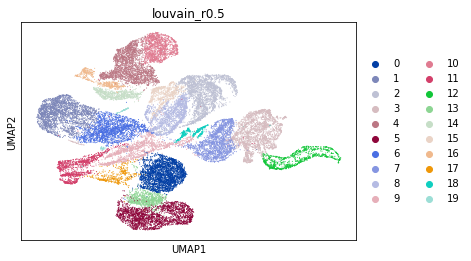

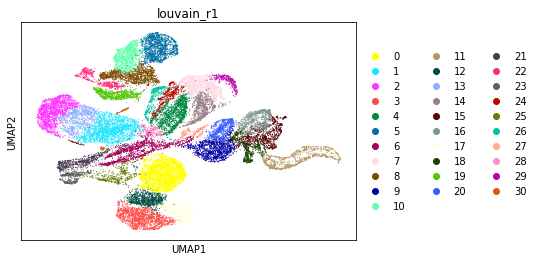

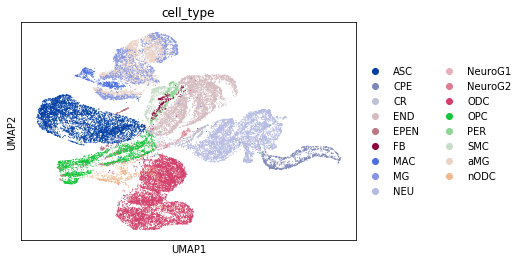

In [15]:
%matplotlib inline
sc.tl.umap(post_adata)
sc.pl.umap(post_adata, color='louvain_r0.5')
sc.pl.umap(post_adata, color='louvain_r1')
sc.pl.umap(post_adata, color='cell_type')

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3

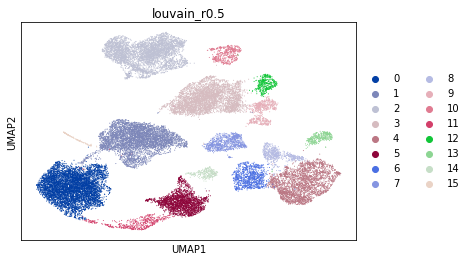

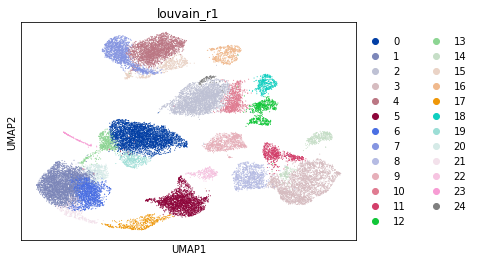

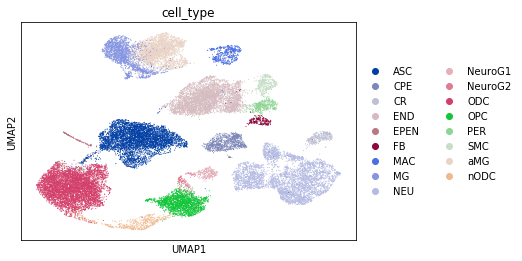

In [16]:
import anndata
import scanpy as sc
post_adata2 = anndata.AnnData(X=latent)
post_adata2.obsm["matrix"] = matrix
post_adata2.obsm["X_scVI"] = np.array(latent)
post_adata2.obs['cell_type'] = np.array(info_df['cell_type'])
post_adata2.obs['label'] = np.array(range(len(info_df)))
post_adata2.obs['cell'] = pd.Series(info_df.index, dtype="category")
post_adata2.obs['region'] = np.array(info_df['region'])
post_adata2.obs['dataset'] = np.array(info_df['dataset'])
post_adata2.obs['treatment'] = np.array(info_df['treatment'])
sc.pp.neighbors(post_adata2)
sc.tl.louvain(post_adata2, resolution=0.5, key_added='louvain_r0.5', random_state=10)
sc.tl.louvain(post_adata2, resolution=1, key_added='louvain_r1', random_state=10)
%matplotlib inline
sc.tl.umap(post_adata2)
sc.pl.umap(post_adata2, color='louvain_r0.5')
sc.pl.umap(post_adata2, color='louvain_r1')
sc.pl.umap(post_adata2, color='cell_type')

In [19]:
class CompressedSensingClass(object):
    def __init__(self,matrix,latent,info_df,
                 metric='cell_type',
                 nblanks=None,
                 npos=50,
                 nbits=18,
                 ncpu=1,
                 pop_ncpu=1,
                 keepers=10,
                 mutation_rate=0.1,
                 offspring_number=0,
                 mutation_number=0,
                 k=100,
                 sample=1000,
                 survivors=[],
                 iterations=100,
                 base_path='',
                 color='r',
                 fresh=True,
                 verbose=True):
        self.metric = metric
        self.info_df = info_df
        self.cell_types = self.info_df.cell_type.unique()
        self.fresh = fresh
        self.verbose = verbose
        if base_path == '':
            base_path = os.path.join(os.getcwd(),'Results')
        self.base_path = base_path
        if not os.path.exists(self.base_path):
            os.mkdir(self.base_path)
        else:
            print('Found Existing Path\n',self.base_path)
            if self.fresh:
                print('base_path already exists and will be overwritten')
                shutil.rmtree(self.base_path)
                os.mkdir(self.base_path)
            else:
                print('loading dict from file isnt supported yet')
        self.cells = list(matrix.columns)
        self.ncells = len(self.cells)
        if nblanks==None:
            nblanks = npos
        blanks = pd.DataFrame(np.zeros((nblanks,self.ncells)),index=['blank'+str(i)for i in range(nblanks)],columns=self.cells)
        self.matrix = pd.concat([matrix,blanks])
        self.gene_variance = np.std(self.matrix ,axis=1)
        self.nblanks = nblanks
        del matrix
        self.genes = list(self.matrix.index)
        self.ngenes = len(self.genes)
        self.npos = npos
        self.nbits = nbits
        self.ncpu = ncpu
        self.pop_ncpu = pop_ncpu
        self.keepers = keepers
        self.ideal = np.zeros(self.ngenes)
        self.ideal[0:npos] = 1
        self.ideal = list(self.ideal)
        self.mutation_rate = mutation_rate
        self.offspring_number = offspring_number
        self.mutation_number = mutation_number
        self.k = k # could infer
        self.sample = sample
        self.survivors = survivors
        self.iterations = iterations
        self.color = color

    def generate_random(self):
        species = np.zeros((self.ngenes,self.nbits))
        for i in range(self.nbits):
            x = random.sample(list(range(self.ngenes)),self.npos)
            species[x,i] = 1
        return species

    def generate_starting_survivors(self):
        survivors = []
        for k in range(self.keepers):
            survivors.append(self.generate_random())
        self.survivors = survivors

    def generate_mutations(self,species):
        mutated = species.copy()
        for y in range(self.nbits):
            for x in random.sample(list(range(self.ngenes)),int(self.mutation_rate*self.ngenes)):
                mutated[x,y] = random.sample(self.ideal,1)[0]
        return mutated

    def generate_offspring(self,species,mate):
        offspring = species.copy()
        for y in range(self.nbits):
            for x in random.sample(list(range(self.ngenes)),int(self.ngenes/2)):
                offspring[x,y] = mate[x,y]
        return offspring

    def generate_progenerators(self):
        progenerators = self.survivors.copy()
        for species in self.survivors:
            for i in range(self.offspring_number):
                mate = self.survivors[random.randint(0,self.keepers-1)].copy()
                progenerators.append(self.generate_offspring(species,mate))
        self.progenerators = progenerators

    def pfunc_generate_mutations(self,species):
        ppopulation = []
        for i in range(self.mutation_number):
            ppopulation.append(self.generate_mutations(species))
        return ppopulation

    def generate_population(self):
        population = self.progenerators.copy()
        if self.mutation_number>0:
            if self.pop_ncpu==1:
                for species in self.progenerators:
                    for i in range(self.mutation_number):
                        population.append(self.generate_mutations(species))
            else:
                sys.stdout.flush()
                with Pool(self.pop_ncpu) as p:
                    for ppopulation in p.imap(self.pfunc_generate_mutations,self.progenerators,chunksize=1):
                        for species in ppopulation:
                            population.append(species)
                sys.stdout.flush()
        self.population = population

    def generate_compressed(self,species):
        compressed = pd.DataFrame(index=self.cells)
        temp_matrix = np.array(self.matrix)
        out = []
        for i in range(self.nbits):
            compressed[i] = np.sum(np.multiply(temp_matrix,species[:,i][...,None]),axis=0)
        return compressed

    def calculate_metric(self,compressed):
        X = np.array(compressed.copy())
        cells = np.array(self.cells)
        n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
        dist = euclidean_distances(X, X[n,:])
        rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
        metrics = []
        correlations = []
        for i,idx in enumerate(n):
            cell = cells[idx]
            knn = cells[rank[:,i]]
            knn = knn[knn!=cell]
            sig = self.matrix[cell]
            avg = np.average(self.matrix[knn[1:]],axis=1)
            correlation = spearmanr(sig,avg)[0]
            if self.metric =='imputation':
                metric = 1-np.nanmean(np.abs((sig-avg)/self.gene_variance))
            elif self.metric == 'cell_type':
                cell = self.info_df.loc[knn[0]].cell_type
                temp_df = self.info_df.loc[knn[1:]]
                metric = len(temp_df[temp_df.cell_type==cell])/self.k
            elif self.metric == 'dendogram':
                print('Not implemented')
#             metric = np.divide(np.sqrt(np.sum(np.square(np.subtract(sig,avg)))),self.nbits)
            correlation = spearmanr(sig,avg)[0]
            metrics.append(metric)
            correlations.append(correlation)
        metric = np.average(metrics)
        correlation = np.average(correlations)
        return metric,correlation

    def pfunc(self,species):
        compressed = self.generate_compressed(species)
        metric,correlation = self.calculate_metric(compressed)
        return species,compressed,metric,correlation
    
    def selection(self):
        new_population = []
        compresseds = []
        metrics = []
        correlations = []
        if self.ncpu==1:
            for species in tqdm.tqdm(self.population):
                species,compressed,metric,correlation = self.pfunc(species)
                new_population.append(species)
                compresseds.append(compressed)
                metrics.append(metric)
                correlations.append(correlation)
        else:
            sys.stdout.flush()
            with Pool(self.ncpu) as p:
                for species,compressed,metric,correlation in tqdm.tqdm(p.imap(self.pfunc,self.population,chunksize=1),total=len(self.population)):
                    new_population.append(species)
                    compresseds.append(compressed)
                    metrics.append(metric)
                    correlations.append(correlation)
            sys.stdout.flush()
        df = pd.DataFrame(index=range(len(self.population)))
        df['population'] = new_population
        df['metrics'] = metrics
        df['compresseds'] = compresseds
        df['correlations'] = correlations
        df = df.sort_values('metrics',ascending=False)
        survivors = df.iloc[:self.keepers]
        self.metrics = list(survivors['metrics'])
        self.compresseds = list(survivors['compresseds'])
        self.correlations = list(survivors['correlations'])
        self.survivors = list(survivors['population'])
        self.elite_survivor = self.survivors[0]
    
    def populate(self):
        self.generate_progenerators()
        self.generate_population()
            
    def evolve(self):
        start_time = time.time()
        self.X = []
        self.Y = []
        self.max = []
        self.min = []
        if len(self.survivors) != self.keepers:
            self.generate_starting_survivors()
        display.clear_output(wait=True)
        for I in range(self.iterations):
            if self.verbose:
                print('Iteration '+str(I))
            self.populate()
            self.selection()
            pickle.dump(self.elite_survivor,open(os.path.join(self.base_path,str('elite_survivor_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.survivors,open(os.path.join(self.base_path,str('survivors_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.metrics,open(os.path.join(self.base_path,str('metrics_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.compresseds,open(os.path.join(self.base_path,str('compresseds_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.correlations,open(os.path.join(self.base_path,str('correlations_'+str(I)+'.pkl')),'wb'))
            avg = np.average(self.metrics)
            std = np.std(self.metrics) 
            self.X.append((time.time()-start_time)/(60*60))
            self.Y.append(avg)
            self.max.append(avg+std)
            self.min.append(avg-std)
            if self.verbose:
#                 pl.plot(self.X,np.log10(self.Y),c='k',linewidth=1)
#                 pl.fill_between(self.X,np.log10(self.max),np.log10(self.min),color=self.color)
                pl.plot(self.X,self.Y,c='k',linewidth=1)
                pl.fill_between(self.X,self.max,self.min,color=self.color)
                if self.metric =='imputation':
                    pl.ylabel('Average Zscore')
                elif self.metric == 'cell_type':
                    pl.ylabel('Average % Accurate')
                elif self.metric == 'dendogram':
                    pl.ylabel('Average metric')
                pl.xlabel('Time Hours')
                display.clear_output(wait=True)
                display.display(pl.gcf())
            if I>10:
                if np.average(self.Y[-5:])==self.Y[-1]:
                    break
        if self.verbose:
            display.clear_output(wait=True)
            print('Average Correlation:',round(np.average(self.correlations),4))
            print('Standard Deviation:',round(np.std(self.correlations),4))


In [20]:
genes

""
Reps1
Soga3
Rps15
Anks1b
Eea1
...
n-R5s71
n-R5s72
n-R5s85
n-R5s88


In [25]:
import shutil
matrix_df = pd.DataFrame(matrix.T,index=genes.index,columns=info_df.index)
CSC = CompressedSensingClass(matrix_df,latent,info_df,
                             npos=50,
                             nbits=18,
                             ncpu=30,
                             pop_ncpu=30,
                             keepers=10,
                             mutation_rate=0.3,
                             offspring_number=0,
                             mutation_number=2,
                             k=50,
                             sample=0.05,
                             survivors=[],
                             iterations=100,
                             base_path='/bigstore/GeneralStorage/Zach/CSI/test',
                             color='r',
                             fresh=True,
                             verbose=True)

Found Existing Path
 /bigstore/GeneralStorage/Zach/CSI/test
base_path already exists and will be overwritten


In [27]:
import random
species = np.zeros((CSC.ngenes,CSC.nbits))
for i in range(CSC.nbits):
    x = random.sample(list(range(CSC.ngenes)),CSC.npos)
    species[x,i] = 1
compressed = CSC.generate_compressed(species)

KeyboardInterrupt: 

In [28]:
compressed = pickle.load(open('/bigstore/GeneralStorage/Zach/CSI/imputation/compresseds_71.pkl','rb'))[0]


In [34]:
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import euclidean_distances
metric,correlation = CSC.calculate_metric(compressed)

In [51]:
Imputed_type = []
dist = euclidean_distances(X, X[n,:])
for i in compressed.iterrows():
    pass

In [133]:
self = CSC
self.sample = 1
X = np.array(compressed.copy())
cells = np.array(self.cells)
n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
dist = euclidean_distances(X, X[n,:])
rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
metrics = []
correlations = []
sample_cells = []
for i,idx in enumerate(n):
    sample_cells.append(cells[idx])
sample_cells_df = pd.DataFrame([i.split('_')[-1] for i in sample_cells],index=sample_cells,columns=['cell_type'])
cell_types = list(info_df.cell_type.unique())
cell_types.sort()
cell_types_idx = pd.DataFrame(range(len(cell_types)),index=cell_types)
cell_type_matrix = np.zeros_like(rank)
for x in range(rank.shape[0]):
    for y in range(rank.shape[1]):
        cell_type_matrix[x,y] = cell_types_idx.loc[cells[rank[x,y]].split('_')[-1]].iloc[0]

In [134]:
from scipy.stats import mode
real = cell_type_matrix[0,:]
imputed = mode(cell_type_matrix[1:,:],axis=0).mode.T[:,0]

In [147]:
imputed

array([ 0, 13, 15, ...,  0,  0, 13])

In [139]:
cell_types_idx

,0
ASC,0
CPE,1
CR,2
END,3
EPEN,4
FB,5
MAC,6
MG,7
NEU,8
NeuroG1,9


In [150]:
temp = pd.DataFrame(cell_types_idx.index,index=cell_types_idx[0])
imputed_cell_types = pd.DataFrame([temp.loc[i].iloc[0] for i in imputed],index=sample_cells,columns=['imputed'])
imputed_cell_types

,imputed
S2Hip_CTTATGGATCTA_ASC,ASC
S2Hip_GGGACATGCACA_END,PER
Sham6Hip_ATATTCAGGACG_aMG,aMG
T2Hip_CCGCCCAGAGGT_END,END
TBI5Hip_GTTTTAGGTCGA_MAC,MAC
...,...
T3Hip_GCTGGGCCACAG_ASC,ASC
TBI5Hip_TCCTCAGGCACG_NEU,NEU
TBI5Hip_TAATCCTTCCAT_ASC,ASC
TBI3Hip_AACATGCACGGA_ASC,ASC


In [152]:
info_df['imputed_cell_type'] = imputed_cell_types
info_df

,region,dataset,barcode,cell_type,treatment,imputed_cell_type
S1Hip_CCTTGCCACACT_ODC,Hip,S1,CCTTGCCACACT,ODC,SHAM,ODC
S1Hip_TTCTATTCGTAG_ODC,Hip,S1,TTCTATTCGTAG,ODC,SHAM,ODC
S1Hip_TTGGGCCCACCG_ODC,Hip,S1,TTGGGCCCACCG,ODC,SHAM,ODC
S1Hip_ATGTACGCCGTG_ODC,Hip,S1,ATGTACGCCGTG,ODC,SHAM,ODC
S1Hip_CCAGAATAATTT_ODC,Hip,S1,CCAGAATAATTT,ODC,SHAM,ODC
...,...,...,...,...,...,...
TBI5Hip_GGTATTGACACC_EPEN,Hip,TBI5,GGTATTGACACC,EPEN,TBI,ASC
TBI5Hip_TCCCACGCCAAC_EPEN,Hip,TBI5,TCCCACGCCAAC,EPEN,TBI,EPEN
TBI5Hip_TTCCTGTAGACC_EPEN,Hip,TBI5,TTCCTGTAGACC,EPEN,TBI,EPEN
TBI5Hip_ATTTAATTGAGC_EPEN,Hip,TBI5,ATTTAATTGAGC,EPEN,TBI,EPEN


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'cell_type' as categorical
... storing 'imputed_cell_type' as categorical
... storing 'region' as categorical
... storing 'dataset' as categorical
... storing 'treatment' as categorical


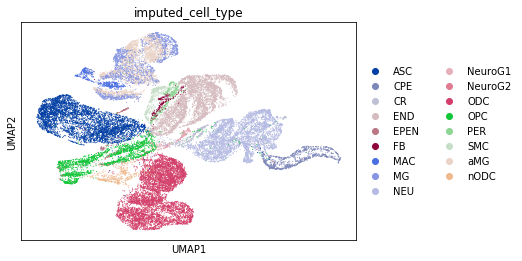

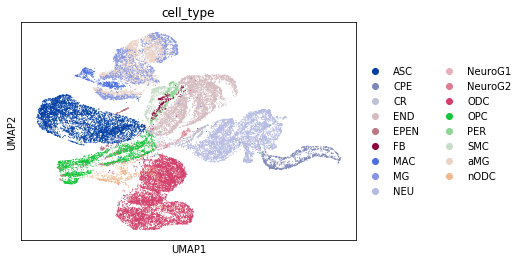

In [154]:
import anndata
import scanpy as sc
post_adata = anndata.AnnData(X=matrix)
post_adata.obsm["matrix"] = matrix
post_adata.obsm["X_scVI"] = np.array(latent)
post_adata.obs['cell_type'] = np.array(info_df['cell_type'])
post_adata.obs['imputed_cell_type'] = np.array(info_df['imputed_cell_type'])
post_adata.obs['label'] = np.array(range(len(info_df)))
post_adata.obs['cell'] = pd.Series(info_df.index, dtype="category")
post_adata.obs['region'] = np.array(info_df['region'])
post_adata.obs['dataset'] = np.array(info_df['dataset'])
post_adata.obs['treatment'] = np.array(info_df['treatment'])
%matplotlib inline
sc.pp.neighbors(post_adata)
sc.tl.umap(post_adata)
sc.pl.umap(post_adata, color='imputed_cell_type')
sc.pl.umap(post_adata, color='cell_type')

Transforming to str index.
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'cell_type' as categorical
... storing 'imputed_cell_type' as categorical
... storing 'region' as categorical
... storing 'dataset' as categorical
... storing 'treatment' as categorical


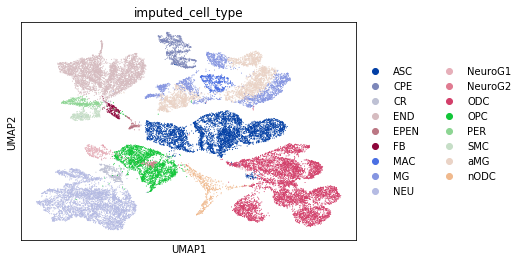

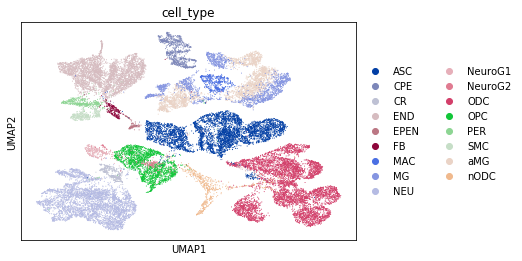

In [155]:
import anndata
import scanpy as sc
post_adata3 = anndata.AnnData(X=compressed)
post_adata3.obsm["matrix"] = matrix
post_adata3.obsm["X_scVI"] = np.array(latent)
post_adata3.obs['cell_type'] = np.array(info_df['cell_type'])
post_adata3.obs['imputed_cell_type'] = np.array(info_df['imputed_cell_type'])
post_adata3.obs['label'] = np.array(range(len(info_df)))
post_adata3.obs['cell'] = pd.Series(info_df.index, dtype="category")
post_adata3.obs['region'] = np.array(info_df['region'])
post_adata3.obs['dataset'] = np.array(info_df['dataset'])
post_adata3.obs['treatment'] = np.array(info_df['treatment'])
%matplotlib inline
sc.pp.neighbors(post_adata3)
sc.tl.umap(post_adata3)
sc.pl.umap(post_adata3, color='imputed_cell_type')
sc.pl.umap(post_adata3, color='cell_type')

In [ ]:
imputed_cell_types = pd.DataFrame([cell_types_idx[i] for i in imputed],index=sample_cells,columns=['imputed'])
imputed_cell_types

In [115]:
cell_type_dict = {}
for idx in cell_types_idx[0]:
    cell_type_dict[idx] = []
for i,r in enumerate(real):
    cell_type_dict[r].append(imputed[i])

In [119]:
confusion_matrix = np.zeros((len(cell_types),len(cell_types)))
for key,imlist in cell_type_dict.items():
    for cell_type,n in Counter(imlist).items():
        confusion_matrix[key,cell_type]= n/len(imlist)

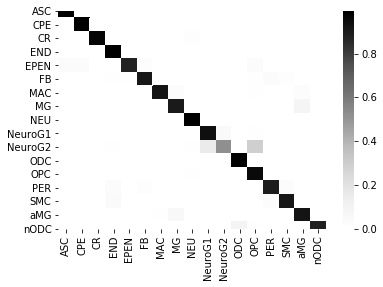

In [132]:
import seaborn as sns
sns.heatmap(pd.DataFrame(confusion_matrix,index=cell_types_idx.index,columns = cell_types_idx.index),cmap='Greys')
plt.show()

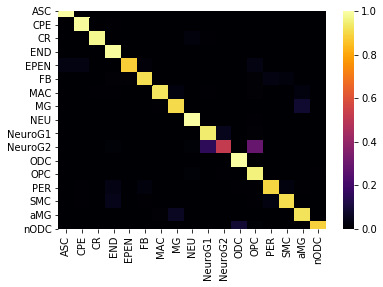

In [165]:
%matplotlib inline
import seaborn as sns
sns.heatmap(pd.DataFrame(confusion_matrix,index=cell_types_idx.index,columns = cell_types_idx.index),cmap='YlOrBr',vmin=0,vmax=1)
plt.show()

In [ ]:
for i,idx in enumerate(n):
    cell = cells[idx]
    knn = cells[rank[:,i]]
    knn = knn[knn!=cell]
    

In [67]:
idx = n[0]
cell = cells[idx]
knn = cells[rank[:,i]]
knn = knn[knn!=cell]
cell = self.info_df.loc[knn[0]].cell_type
temp_df = self.info_df.loc[knn[1:]]

In [70]:
from collections import defaultdict, Counter
Counter(temp_df.cell_type)

Counter({'ODC': 50})

In [ ]:
metric = len(temp_df[temp_df.cell_type==cell])/self.k

In [35]:
print(metric,correlation)

0.9357655172413794 0.9945204188164393


Transforming to str index.
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'cell_type' as categorical
... storing 'region' as categorical
... storing 'dataset' as categorical
... storing 'treatment' as categorical


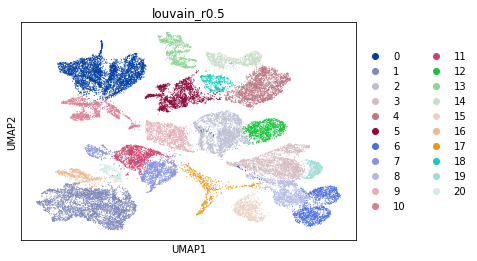

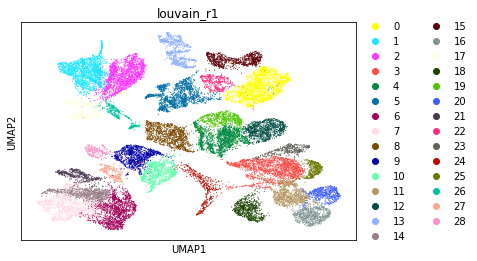

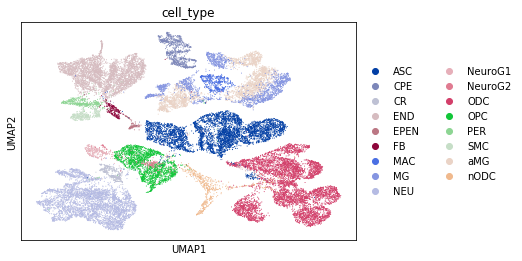

In [36]:
import anndata
import scanpy as sc
post_adata3 = anndata.AnnData(X=compressed)
post_adata3.obsm["matrix"] = matrix
post_adata3.obsm["X_scVI"] = np.array(latent)
post_adata3.obs['cell_type'] = np.array(info_df['cell_type'])
post_adata3.obs['label'] = np.array(range(len(info_df)))
post_adata3.obs['cell'] = pd.Series(list(info_df.index), dtype="category")
post_adata3.obs['region'] = np.array(info_df['region'])
post_adata3.obs['dataset'] = np.array(info_df['dataset'])
post_adata3.obs['treatment'] = np.array(info_df['treatment'])
sc.pp.neighbors(post_adata3)
sc.tl.louvain(post_adata3, resolution=0.5, key_added='louvain_r0.5', random_state=10)
sc.tl.louvain(post_adata3, resolution=1, key_added='louvain_r1', random_state=10)
%matplotlib inline
sc.tl.umap(post_adata3)
sc.pl.umap(post_adata3, color='louvain_r0.5')
sc.pl.umap(post_adata3, color='louvain_r1')
sc.pl.umap(post_adata3, color='cell_type')

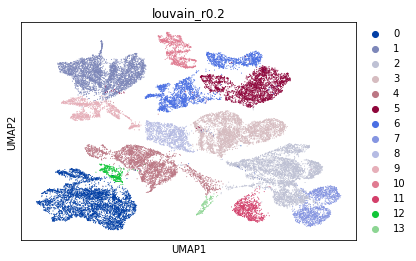

In [44]:
sc.tl.louvain(post_adata3, resolution=0.2, key_added='louvain_r0.2', random_state=10)
sc.pl.umap(post_adata3, color='louvain_r0.2')

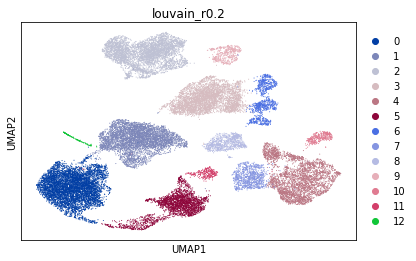

In [45]:
sc.tl.louvain(post_adata2, resolution=0.2, key_added='louvain_r0.2', random_state=10)
sc.pl.umap(post_adata2, color='louvain_r0.2')

... storing 'latent_louvain_r0.2' as categorical
... storing 'compressed_louvain_r0.2' as categorical


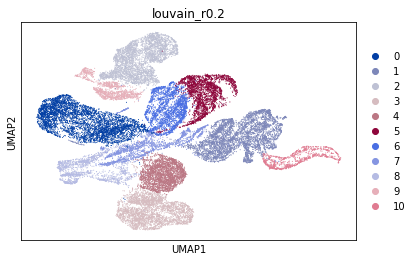

In [47]:
sc.tl.louvain(post_adata, resolution=0.2, key_added='louvain_r0.2', random_state=10)
sc.pl.umap(post_adata, color='louvain_r0.2')

In [40]:
post_adata.obs['latent_louvain_r0.5'] = np.array(post_adata2.obs['louvain_r0.5'])
post_adata.obs['latent_louvain_r0.5'] = np.array(post_adata2.obs['louvain_r1'])
post_adata.obs['compressed_louvain_r0.5'] = np.array(post_adata3.obs['louvain_r0.5'])
post_adata.obs['compressed_louvain_r0.5'] = np.array(post_adata3.obs['louvain_r1'])

In [46]:
post_adata.obs['latent_louvain_r0.2'] = np.array(post_adata2.obs['louvain_r0.2'])
post_adata.obs['compressed_louvain_r0.2'] = np.array(post_adata3.obs['louvain_r0.2'])

... storing 'latent_louvain_r0.5' as categorical
... storing 'compressed_louvain_r0.5' as categorical


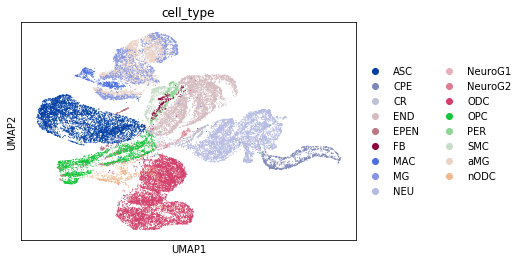

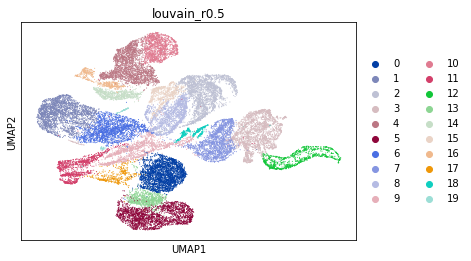

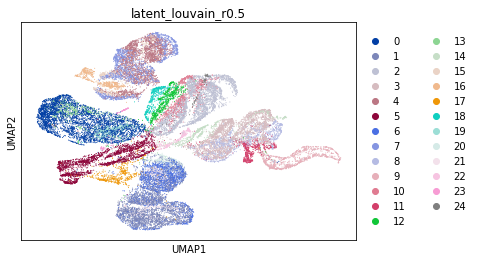

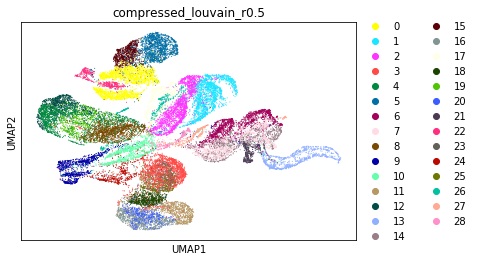

In [41]:
%matplotlib inline
sc.pl.umap(post_adata, color='cell_type')
sc.pl.umap(post_adata, color='louvain_r0.5')
sc.pl.umap(post_adata, color='latent_louvain_r0.5')
sc.pl.umap(post_adata, color='compressed_louvain_r0.5')

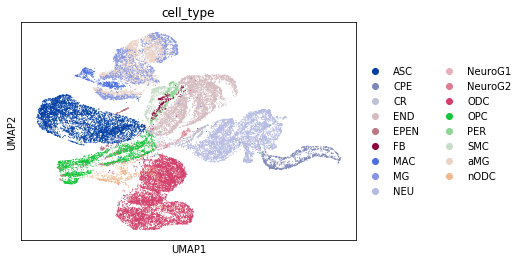

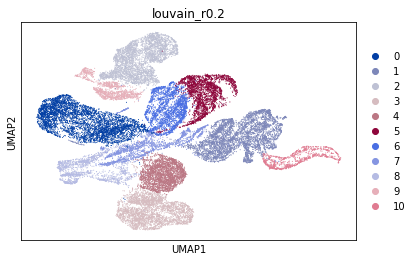

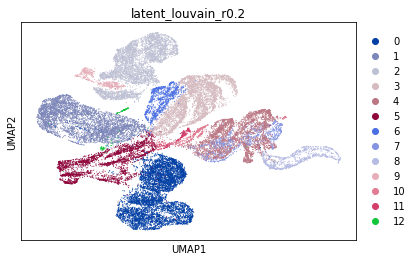

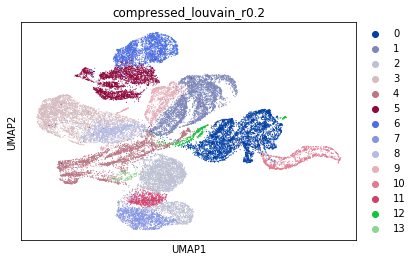

In [48]:
%matplotlib inline
sc.pl.umap(post_adata, color='cell_type')
sc.pl.umap(post_adata, color='louvain_r0.2')
sc.pl.umap(post_adata, color='latent_louvain_r0.2')
sc.pl.umap(post_adata, color='compressed_louvain_r0.2')

In [173]:
post_adata.obs['id'] = np.array(pd.Series(list(info_df.index), dtype="category"))
post_adata.obs['id'] = post_adata.obs['id'].astype('category')
post_adata.obs

,cell_type,imputed_cell_type,label,cell,region,dataset,treatment,id
0,ODC,ODC,0,NaN,Hip,S1,SHAM,S1Hip_CCTTGCCACACT_ODC
1,ODC,ODC,1,NaN,Hip,S1,SHAM,S1Hip_TTCTATTCGTAG_ODC
2,ODC,ODC,2,NaN,Hip,S1,SHAM,S1Hip_TTGGGCCCACCG_ODC
3,ODC,ODC,3,NaN,Hip,S1,SHAM,S1Hip_ATGTACGCCGTG_ODC
4,ODC,ODC,4,NaN,Hip,S1,SHAM,S1Hip_CCAGAATAATTT_ODC
...,...,...,...,...,...,...,...,...
29008,EPEN,ASC,29008,NaN,Hip,TBI5,TBI,TBI5Hip_GGTATTGACACC_EPEN
29009,EPEN,EPEN,29009,NaN,Hip,TBI5,TBI,TBI5Hip_TCCCACGCCAAC_EPEN
29010,EPEN,EPEN,29010,NaN,Hip,TBI5,TBI,TBI5Hip_TTCCTGTAGACC_EPEN
29011,EPEN,EPEN,29011,NaN,Hip,TBI5,TBI,TBI5Hip_ATTTAATTGAGC_EPEN


In [ ]:
# dendogram
sc.tl.dendrogram(post_adata, groupby='id')
sc.pl.dendrogram(post_adata)

In [ ]:
latent

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In [8]:
def allow_notebook_for_test():
    print("Testing the basic tutorial notebook")


test_mode = False
save_path = "/bigstore/GeneralStorage/Zach/CSI"
n_epochs_all = None
show_plot = True
if not os.path.exists(save_path):
    os.mkdir(save_path)
if not test_mode:
    save_path = "../../data"

In [9]:
SCMatrix = pd.read_csv('/home/rlittman/Hippocampus_TBI_scRNAseq_data/TBI.SHAM.countdata.with.celltypes.csv.gz',sep=' ')
SCMatrix.head()

,S1Hip_CCTTGCCACACT_ODC,S1Hip_TTCTATTCGTAG_ODC,S1Hip_TTGGGCCCACCG_ODC,S1Hip_ATGTACGCCGTG_ODC,S1Hip_CCAGAATAATTT_ODC,S1Hip_CCGCTCAAGTCC_ODC,S1Hip_GGAGGATTGGGT_ODC,S1Hip_AGTCACTGTTTA_ODC,S1Hip_TAAAACCTATCG_ODC,S1Hip_CCGTCCCGAGTT_ODC,...,TBI5Hip_TCCTGAGACGCT_EPEN,TBI5Hip_TTGCGCAAAACG_EPEN,TBI5Hip_ACGCCGAGTTGC_EPEN,TBI5Hip_CAGCATATGGCG_EPEN,TBI5Hip_GACATCATTCAT_EPEN,TBI5Hip_GGTATTGACACC_EPEN,TBI5Hip_TCCCACGCCAAC_EPEN,TBI5Hip_TTCCTGTAGACC_EPEN,TBI5Hip_ATTTAATTGAGC_EPEN,TBI5Hip_ATCCCTCGCAGC_EPEN
Reps1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Soga3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rps15,2,1,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
Anks1b,1,0,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Eea1,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,1,0,0,0


In [3]:
# Very Slow
from scvi.dataset import LoomDataset, CsvDataset, Dataset10X, DownloadableAnnDataset
# Loading a local dataset 
save_path = '/bigstore/binfo/mouse/Hippocampus/'
local_csv_dataset = CsvDataset(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.csv.gz'),
                               save_path=save_path,
                               sep=' ',UnsupervisedTrainer
                               batch_ids_file=os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.batch_ids.csv'),
                               compression='gzip')

[2020-01-07 15:26:14,304] INFO - scvi.dataset.csv | Preprocessing dataset
[2020-01-07 15:43:27,429] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2020-01-07 15:43:36,097] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-07 15:43:36,101] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-07 15:44:50,384] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-07 15:44:53,615] INFO - scvi.dataset.dataset | Downsampled from 29013 to 29013 cells
[2020-01-07 15:44:54,415] INFO - scvi.dataset.dataset | Not subsampling. No parameter given


In [4]:
local_csv_dataset.batch_indices

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [11],
       [11],
       [11]], dtype=uint16)

In [5]:
np.unique(local_csv_dataset.batch_indices)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint16)

In [9]:

n_epochs = 50 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = True
use_cuda = True

# Train the model and output model likelihood every 5 epochs
vae = VAE(local_csv_dataset.nb_genes, n_batch=local_csv_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    vae, 
    local_csv_dataset, 
    train_size=0.9 if not test_mode else 0.5, 
    use_cuda=use_cuda,
    frequency=5,
)
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 50/50 [09:59<00:00, 12.63s/it]


(2176.5498036028876, 3500)

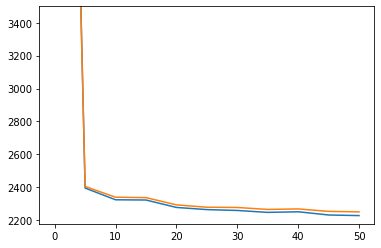

In [11]:
# Plotting the likelihood change across the 50 epochs of training: 
# blue for training error and orange for testing error. 
%matplotlib inline
elbo_train = trainer.history["elbo_train_set"]
elbo_test = trainer.history["elbo_test_set"]
x = np.linspace(0, 50, (len(elbo_train)))
plt.plot(x, elbo_train)
plt.plot(x, elbo_test)
plt.ylim(min(elbo_train)-50, 3500)

In [23]:
save_path = '/bigstore/binfo/mouse/Hippocampus/'
info = pd.read_csv(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.batch_ids.csv'),index_col=0)

In [12]:
full = trainer.create_posterior(trainer.model, local_csv_dataset, indices=np.arange(len(local_csv_dataset)))
print("Entropy of batch mixing :", full.entropy_batch_mixing())

Entropy of batch mixing : None


In [13]:
latent, batch_indices, labels = full.sequential().get_latent()

In [49]:
latent.shape

(29013, 10)

In [18]:
local_csv_dataset.labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint16)

In [26]:
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()

In [151]:
full

In [142]:
normalized_values.T

array([[4.43274002e-05, 3.62722203e-05, 3.20440813e-05, ...,
        4.02939659e-05, 4.25558610e-05, 2.29702200e-05],
       [1.23398349e-04, 1.09782974e-04, 1.36354924e-04, ...,
        1.53332090e-04, 2.03838630e-04, 1.49677478e-04],
       [6.18085382e-04, 5.28949604e-04, 5.71626879e-04, ...,
        3.31825169e-04, 2.18183457e-04, 4.29976790e-04],
       ...,
       [6.50734080e-08, 6.68181812e-08, 8.60638139e-08, ...,
        1.94843395e-07, 2.19250865e-07, 1.06108125e-07],
       [6.30187600e-08, 4.03559213e-08, 5.55522917e-08, ...,
        2.85818146e-07, 3.43675026e-07, 2.01604749e-07],
       [3.95097288e-08, 2.90170341e-08, 5.40099094e-08, ...,
        5.19159357e-07, 5.74373985e-07, 2.89206582e-07]], dtype=float32)

In [141]:
from sklearn.decomposition import PCA
pca = PCA().fit(normalized_values.T)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

ValueError: Too large work array required -- computation cannot be performed with standard 32-bit LAPACK.

In [ ]:
from sklearn.decomposition import IncrementalPCA
import csv
import sys
import numpy as np
import pandas as pd

dataset = normalized_values.T
chunksize_ = 5 * 25000
dimensions = 300

reader = pd.read_csv(dataset, sep = ',', chunksize = chunksize_)
sklearn_pca = IncrementalPCA(n_components=dimensions)
for chunk in reader:
    y = chunk.pop("Y")
    sklearn_pca.partial_fit(chunk)

# Computed mean per feature
mean = sklearn_pca.mean_
# and stddev
stddev = np.sqrt(sklearn_pca.var_)

Xtransformed = None
for chunk in pd.read_csv(dataset, sep = ',', chunksize = chunksize_):
    y = chunk.pop("Y")
    Xchunk = sklearn_pca.transform(chunk)
    if Xtransformed == None:
        Xtransformed = Xchunk
    else:
        Xtransformed = np.vstack((Xtransformed, Xchunk))

In [140]:
normalized_values.shape

(29013, 32355)

In [53]:
import pickle
pickle.dump(latent,open(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.latent.pkl'),'wb'))

In [51]:
import pickle
pickle.dump(normalized_values,open(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.normalized.pkl'),'wb'))

In [52]:
from scipy.sparse import csr_matrix
SCMatrix_Sparse = csr_matrix(normalized_values)

In [54]:
pickle.dump(SCMatrix_Sparse,open(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.normalized_sparse.pkl'),'wb'))

In [46]:
imputed_values

array([[6.46719337e-02, 1.88774616e-01, 9.67040956e-01, ...,
        9.08291404e-05, 8.70585427e-05, 5.54103790e-05],
       [6.22320622e-02, 1.85665205e-01, 8.63353014e-01, ...,
        1.07771622e-04, 6.37615449e-05, 4.60951778e-05],
       [3.85510698e-02, 1.83194578e-01, 7.32870340e-01, ...,
        9.47231674e-05, 6.05932291e-05, 6.06103349e-05],
       ...,
       [2.46160161e-02, 9.80086550e-02, 2.13685781e-01, ...,
        1.05106425e-04, 1.55716625e-04, 2.77890504e-04],
       [2.25811005e-02, 1.09533362e-01, 1.17735371e-01, ...,
        1.16658324e-04, 1.83258890e-04, 3.13991302e-04],
       [8.47687293e-03, 5.31400517e-02, 1.45933852e-01, ...,
        3.72559443e-05, 7.29101521e-05, 1.03429156e-04]], dtype=float32)

In [61]:
np.median(normalized_values)

1.8019362e-06

In [63]:
np.percentile(normalized_values.ravel(),10)

9.260122624255018e-08

In [30]:
genes = pd.read_csv(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.genes.csv'),index_col=0)
genes

""
Reps1
Soga3
Rps15
Anks1b
Eea1
...
n-R5s71
n-R5s72
n-R5s85
n-R5s88


In [31]:
info_df = pd.read_csv(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.info_df.csv'),index_col=0)
info_df

,region,dataset,barcode,cell_type,treatment
S1Hip_CCTTGCCACACT_ODC,Hip,S1,CCTTGCCACACT,ODC,SHAM
S1Hip_TTCTATTCGTAG_ODC,Hip,S1,TTCTATTCGTAG,ODC,SHAM
S1Hip_TTGGGCCCACCG_ODC,Hip,S1,TTGGGCCCACCG,ODC,SHAM
S1Hip_ATGTACGCCGTG_ODC,Hip,S1,ATGTACGCCGTG,ODC,SHAM
S1Hip_CCAGAATAATTT_ODC,Hip,S1,CCAGAATAATTT,ODC,SHAM
...,...,...,...,...,...
TBI5Hip_GGTATTGACACC_EPEN,Hip,TBI5,GGTATTGACACC,EPEN,TBI
TBI5Hip_TCCCACGCCAAC_EPEN,Hip,TBI5,TCCCACGCCAAC,EPEN,TBI
TBI5Hip_TTCCTGTAGACC_EPEN,Hip,TBI5,TTCCTGTAGACC,EPEN,TBI
TBI5Hip_ATTTAATTGAGC_EPEN,Hip,TBI5,ATTTAATTGAGC,EPEN,TBI


In [42]:
normalized_values

array([4.4327400e-05, 3.6272220e-05, 3.2044081e-05, ..., 4.0293966e-05,
       4.2555861e-05, 2.2970220e-05], dtype=float32)

In [114]:
relavent_normalized_values = normalized_values*10**6

In [117]:
total_counts = np.average(relavent_normalized_values,axis=0)

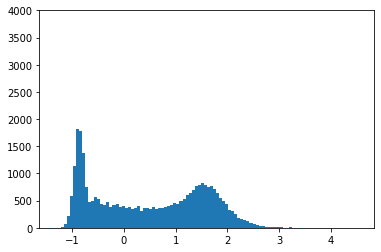

In [126]:
%matplotlib inline
plt.hist(np.log10(total_counts),bins=100)
plt.ylim([0,4000])
# plt.xlim([0,0.2])
plt.show()

In [116]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [121]:
len(total_counts[total_counts>10])

12930

In [143]:
relavent_normalized_df.to_csv()

,S1Hip_CCTTGCCACACT_ODC,S1Hip_TTCTATTCGTAG_ODC,S1Hip_TTGGGCCCACCG_ODC,S1Hip_ATGTACGCCGTG_ODC,S1Hip_CCAGAATAATTT_ODC,S1Hip_CCGCTCAAGTCC_ODC,S1Hip_GGAGGATTGGGT_ODC,S1Hip_AGTCACTGTTTA_ODC,S1Hip_TAAAACCTATCG_ODC,S1Hip_CCGTCCCGAGTT_ODC,...,TBI5Hip_TCCTGAGACGCT_EPEN,TBI5Hip_TTGCGCAAAACG_EPEN,TBI5Hip_ACGCCGAGTTGC_EPEN,TBI5Hip_CAGCATATGGCG_EPEN,TBI5Hip_GACATCATTCAT_EPEN,TBI5Hip_GGTATTGACACC_EPEN,TBI5Hip_TCCCACGCCAAC_EPEN,TBI5Hip_TTCCTGTAGACC_EPEN,TBI5Hip_ATTTAATTGAGC_EPEN,TBI5Hip_ATCCCTCGCAGC_EPEN
Reps1,44.327400,36.272220,32.044081,49.884129,44.007866,63.792635,46.131809,59.826943,30.186640,48.974824,...,27.059303,70.520451,42.396328,62.709747,79.230260,34.090790,50.830931,40.293966,42.555861,22.970220
Soga3,123.398349,109.782974,136.354924,148.335690,152.976922,162.084616,140.642354,140.650256,132.285044,125.673556,...,180.996343,174.757413,103.136088,95.595831,239.053974,203.634831,126.504427,153.332090,203.838630,149.677478
Rps15,618.085382,528.949604,571.626879,491.853862,525.095733,691.627967,551.121717,458.639552,477.108551,484.201359,...,214.221203,182.518139,355.961500,282.744382,92.910159,186.528589,264.676928,331.825169,218.183457,429.976790
Anks1b,459.308503,522.124406,609.744049,543.028407,531.675178,521.985290,563.355105,475.368026,548.537704,526.839925,...,85.835818,240.655732,118.229975,105.671781,84.808788,117.727737,108.454573,125.221821,99.685436,124.859187
Eea1,112.507296,80.928352,89.131878,115.719784,100.736157,102.771424,105.085470,114.015180,115.672861,102.114114,...,144.249338,266.324962,410.637062,403.610058,351.218216,119.881945,247.000309,252.515863,237.956105,181.437557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s71,0.087388,0.052603,0.110099,0.164965,0.157601,0.117888,0.152759,0.113376,0.115074,0.067341,...,0.098215,0.234512,0.183525,0.197577,0.664450,0.121717,0.273935,0.220308,0.264033,0.141500
n-R5s72,0.141673,0.093631,0.204440,0.229347,0.212698,0.167051,0.236809,0.156055,0.175050,0.091233,...,0.101362,0.159849,0.159981,0.200117,0.381282,0.123960,0.308591,0.280394,0.297663,0.235680
n-R5s85,0.065073,0.066818,0.086064,0.114509,0.117269,0.102216,0.123325,0.087004,0.070665,0.060330,...,0.086114,0.229471,0.132942,0.144495,0.807705,0.135146,0.264890,0.194843,0.219251,0.106108
n-R5s88,0.063019,0.040356,0.055552,0.085861,0.073322,0.095693,0.093379,0.073943,0.052513,0.046792,...,0.150226,0.195454,0.166025,0.195232,0.777629,0.217313,0.351542,0.285818,0.343675,0.201605


In [144]:
relavent_normalized_df.to_csv(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.relavent_normalized_df.csv'))

In [ ]:
SCMatrix = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.relavent_normalized_df.csv')
SCMatrix.head()

In [ ]:
dataset = []
region = []
barcode = []
cell_type = []
treatment = []
for label in SCMatrix.columns:
    A,B,C = label.split('_')
    cell_type.append(C)
    barcode.append(B)
    region.append('Hip')
    dataset.append(A.split('Hip')[0])
    if 'S' in A:
        treatment.append('SHAM')
    else:
        treatment.append('TBI')
        
print(len(np.unique(region)),' regions')
print(len(np.unique(dataset)),' datasets')
print(len(np.unique(barcode)),' barcodes')
print(len(np.unique(cell_type)),' cell_types')
print(len(np.unique(treatment)),' treatments')
info_df = pd.DataFrame(index=SCMatrix.columns)
info_df['region'] = region
info_df['dataset'] = dataset
info_df['barcode'] = barcode
info_df['cell_type'] = cell_type
info_df['region'] = region
info_df['treatment'] = treatment
info_df
info_df.to_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.info_df.csv')
pd.DataFrame(index = SCMatrix.index).to_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.genes.csv')

In [ ]:
dataset_index = []
datasets = np.unique(dataset)
for d in dataset:
    for i,ds in enumerate(datasets):
        if d==ds:
            dataset_index.append(i)
batch_ids = pd.DataFrame(data=dataset_index,index=SCMatrix.columns,columns=['dataset'])
batch_ids.to_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.batch_ids.csv')

In [123]:
relavent_normalized_df = relavent_normalized_df.T

In [127]:
filtered_normalized_df = relavent_normalized_df[total_counts>10]

In [128]:
filtered_normalized_df

,S1Hip_CCTTGCCACACT_ODC,S1Hip_TTCTATTCGTAG_ODC,S1Hip_TTGGGCCCACCG_ODC,S1Hip_ATGTACGCCGTG_ODC,S1Hip_CCAGAATAATTT_ODC,S1Hip_CCGCTCAAGTCC_ODC,S1Hip_GGAGGATTGGGT_ODC,S1Hip_AGTCACTGTTTA_ODC,S1Hip_TAAAACCTATCG_ODC,S1Hip_CCGTCCCGAGTT_ODC,...,TBI5Hip_TCCTGAGACGCT_EPEN,TBI5Hip_TTGCGCAAAACG_EPEN,TBI5Hip_ACGCCGAGTTGC_EPEN,TBI5Hip_CAGCATATGGCG_EPEN,TBI5Hip_GACATCATTCAT_EPEN,TBI5Hip_GGTATTGACACC_EPEN,TBI5Hip_TCCCACGCCAAC_EPEN,TBI5Hip_TTCCTGTAGACC_EPEN,TBI5Hip_ATTTAATTGAGC_EPEN,TBI5Hip_ATCCCTCGCAGC_EPEN
Reps1,44.327400,36.272220,32.044081,49.884129,44.007866,63.792635,46.131809,59.826943,30.186640,48.974824,...,27.059303,70.520451,42.396328,62.709747,79.230260,34.090790,50.830931,40.293966,42.555861,22.970220
Soga3,123.398349,109.782974,136.354924,148.335690,152.976922,162.084616,140.642354,140.650256,132.285044,125.673556,...,180.996343,174.757413,103.136088,95.595831,239.053974,203.634831,126.504427,153.332090,203.838630,149.677478
Rps15,618.085382,528.949604,571.626879,491.853862,525.095733,691.627967,551.121717,458.639552,477.108551,484.201359,...,214.221203,182.518139,355.961500,282.744382,92.910159,186.528589,264.676928,331.825169,218.183457,429.976790
Anks1b,459.308503,522.124406,609.744049,543.028407,531.675178,521.985290,563.355105,475.368026,548.537704,526.839925,...,85.835818,240.655732,118.229975,105.671781,84.808788,117.727737,108.454573,125.221821,99.685436,124.859187
Eea1,112.507296,80.928352,89.131878,115.719784,100.736157,102.771424,105.085470,114.015180,115.672861,102.114114,...,144.249338,266.324962,410.637062,403.610058,351.218216,119.881945,247.000309,252.515863,237.956105,181.437557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ccl22,1.104955,1.335444,2.055910,1.555296,1.956280,1.313305,1.938598,0.851903,0.959478,0.881177,...,4.611442,4.757056,3.589142,1.307256,3.634379,5.040044,3.901630,3.355529,2.922637,7.637203
Cxcl5,1.729041,0.599706,2.027534,1.991494,1.109222,1.121621,1.941282,1.722821,2.146153,0.916772,...,26.019699,16.257560,21.041777,42.112741,28.002387,29.777651,32.909742,22.753838,32.703945,12.505682
Cxcl13,0.145684,0.130620,0.397339,0.139913,0.161585,0.245314,0.210850,0.177408,0.185060,0.076756,...,41.395597,21.796843,14.063333,9.113709,95.366689,60.621311,22.226834,11.977168,24.863957,10.633667
Gpihbp1,0.259086,0.134767,0.928083,0.297198,0.357847,0.324263,0.324119,0.287054,0.476547,0.139832,...,5.387267,2.318581,2.006261,0.582591,1.639582,10.634796,3.690113,4.136600,4.386326,5.062568


In [130]:
filtered_normalized_df.to_csv(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.filtered_normalized_df.csv'))

In [131]:
import sys
sys.getsizeof(filtered_normalized_df)

3001915598

In [145]:
latent.shape

(29013, 10)

In [150]:
pd.DataFrame(latent,index=info_df.index).to_csv(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.latent.csv.gz'),compression='gzip')

In [134]:
sys.getsizeof(filtered_normalized_df.astype('float16'))

751087058

In [137]:
filtered_normalized_df.astype('float16').to_csv(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.filtered_normalized_df.16bit.csv'))

In [ ]:
import pickle
pickle.dump(filtered_normalized_df,open(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.filtered_normalized_df.pkl'),'wb'))

In [ ]:
import scanpy as sc
sc.pp.pca(scrnaseq, n_comps=50, use_highly_variable=True, svd_solver='arpack')


In [154]:
post_adata.obsm

AxisArrays with keys: X_scVI, X_umap

In [ ]:
import anndata
import scanpy as sc
post_adata = anndata.AnnData(X=local_csv_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs['cell_type'] = np.array([i.split('_')[-1] for i in info.index])
post_adata.obs['batch'] = np.array([local_csv_dataset.batch_indices[i][0] 
                                   for i in range(post_adata.n_obs)])
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["batch"], ax=ax, show=show_plot)

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


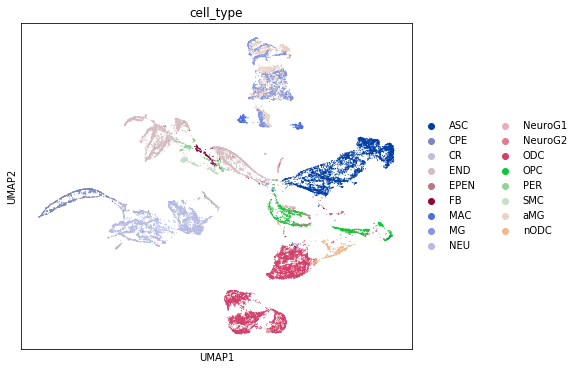

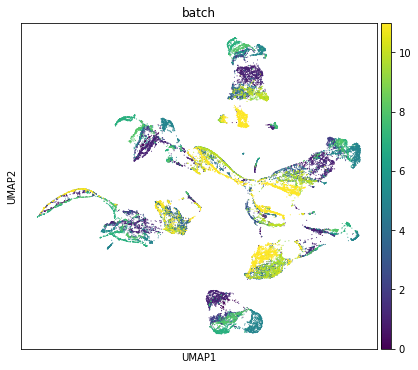

In [156]:
post_adata.obsm["normalized"] = normalized_values
sc.pp.neighbors(post_adata, use_rep="normalized", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["batch"], ax=ax, show=show_plot)

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'cell_type' as categorical


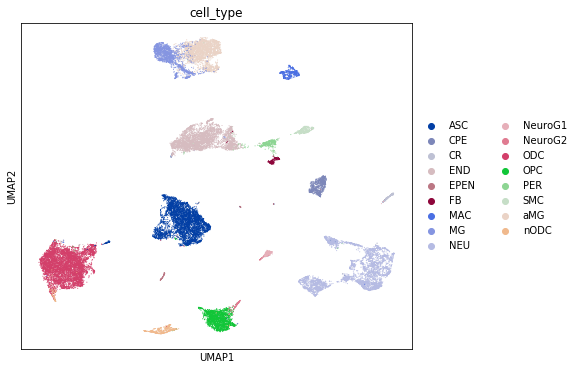

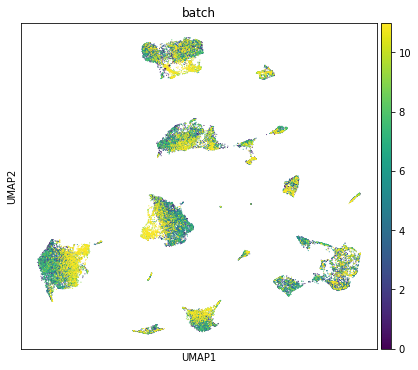

In [25]:
import anndata
import scanpy as sc
post_adata = anndata.AnnData(X=local_csv_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs['cell_type'] = np.array([i.split('_')[-1] for i in info.index])
post_adata.obs['batch'] = np.array([local_csv_dataset.batch_indices[i][0] 
                                   for i in range(post_adata.n_obs)])
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["batch"], ax=ax, show=show_plot)

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


IndexError: Key "cell_type" is not valid observation/variable name/index.

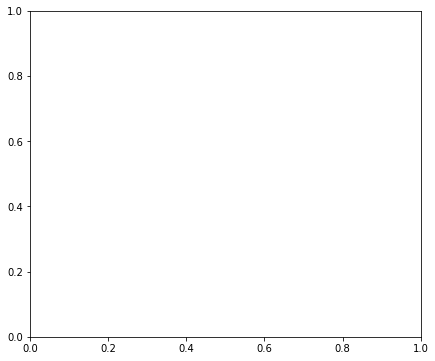

In [26]:
import anndata
import scanpy as sc
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
show_plot = True
compressed = pickle.load(open('/bigstore/GeneralStorage/Zach/CSI/compresseds_46.pkl','rb'))[0]
info_df = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.info_df.csv',index_col=0)
post_adata = anndata.AnnData(X=np.array(compressed))
post_adata.obsm["compressed"] = np.array(compressed)
post_adata.obsm["cell_type"] = np.array([i.split('_')[-1] for i in info_df.index])
sc.pp.neighbors(post_adata, use_rep="compressed", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)

In [32]:
df = pd.DataFrame(post_adata.obsm['X_umap'],index=info_df.index)
df['cell_type'] = info_df['cell_type']
df

,0,1,cell_type
S1Hip_CCTTGCCACACT_ODC,11.121353,6.303915,ODC
S1Hip_TTCTATTCGTAG_ODC,11.336872,6.218030,ODC
S1Hip_TTGGGCCCACCG_ODC,11.191598,6.254745,ODC
S1Hip_ATGTACGCCGTG_ODC,11.317649,6.121414,ODC
S1Hip_CCAGAATAATTT_ODC,11.216731,6.166689,ODC
...,...,...,...
TBI5Hip_GGTATTGACACC_EPEN,-1.608586,-4.244300,EPEN
TBI5Hip_TCCCACGCCAAC_EPEN,-1.404123,-4.451868,EPEN
TBI5Hip_TTCCTGTAGACC_EPEN,-1.399926,-4.447880,EPEN
TBI5Hip_ATTTAATTGAGC_EPEN,-1.425105,-4.447896,EPEN


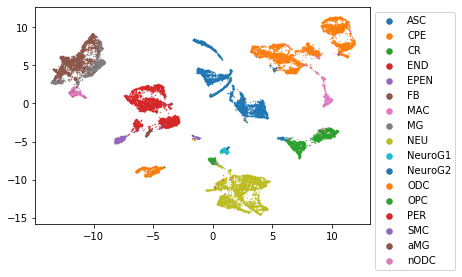

In [64]:
compressed = pickle.load(open('/bigstore/GeneralStorage/Zach/CSI/compresseds_46.pkl','rb'))[0]
info_df = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.info_df.csv',index_col=0)
A = list(df['cell_type'].unique())
A.sort()
for cell_type in A:
    temp_df = df[df['cell_type']==cell_type]
    plt.scatter(temp_df[0],temp_df[1],s=0.1,alpha=1,label=cell_type)
lgnd = plt.legend(bbox_to_anchor=(1, 1, 0, 0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i]._sizes = [30]
plt.show()

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


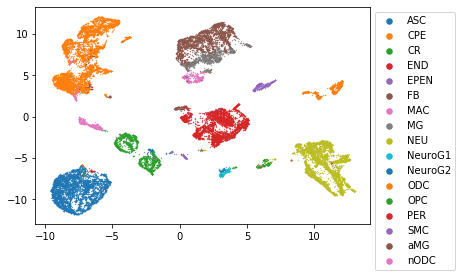

In [67]:
compressed = pickle.load(open('/bigstore/GeneralStorage/Zach/CSI/compresseds_0.pkl','rb'))[0]
info_df = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.info_df.csv',index_col=0)
post_adata = anndata.AnnData(X=np.array(compressed))
post_adata.obsm["compressed"] = np.array(compressed)
post_adata.obsm["cell_type"] = np.array([i.split('_')[-1] for i in info_df.index])
sc.pp.neighbors(post_adata, use_rep="compressed", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)
df = pd.DataFrame(post_adata.obsm['X_umap'],index=info_df.index)
df['cell_type'] = info_df['cell_type']
A = list(df['cell_type'].unique())
A.sort()
for cell_type in A:
    temp_df = df[df['cell_type']==cell_type]
    plt.scatter(temp_df[0],temp_df[1],s=0.1,alpha=1,label=cell_type)
lgnd = plt.legend(bbox_to_anchor=(1, 1, 0, 0))
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i]._sizes = [30]
plt.show()

In [13]:
compressed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
S1Hip_CCTTGCCACACT_ODC,6768.185567,1604.638164,3514.749282,2202.432797,1735.434434,1740.521246,2707.541316,6005.995543,2969.046250,1749.002978,4507.102504,2173.307360,2755.379951,2050.801034,6885.187275,1734.543864,3395.661870,1769.890290
S1Hip_TTCTATTCGTAG_ODC,8731.203231,1606.338543,3969.700973,2354.855657,1975.939565,1145.676227,2676.046789,6357.189008,2768.324112,1500.276873,3541.113107,2169.169638,2797.751320,1659.415840,8085.933518,1856.557126,4354.720232,1300.449692
S1Hip_TTGGGCCCACCG_ODC,6018.932110,1732.443164,3599.836411,2676.909032,1838.280596,1716.400929,2996.985671,5925.797868,3174.940166,1771.060054,6384.869871,2126.939805,2846.743809,1917.857041,7019.347793,1999.822717,3890.770911,1655.233976
S1Hip_ATGTACGCCGTG_ODC,8077.144364,1848.545484,3605.160782,2358.268306,2069.684088,1462.366289,2641.954317,6369.339577,3063.246481,1825.696276,5374.471305,2465.827135,3115.745315,2184.653890,7816.093695,2103.549597,3804.195011,1705.235516
S1Hip_CCAGAATAATTT_ODC,7067.519753,1838.469934,3470.570412,2502.907893,2149.100233,1492.142938,2853.604032,5778.905754,3159.293316,1915.560664,5272.336725,2320.764678,3006.591459,2187.672511,7279.069042,1859.757836,3650.797790,1766.262645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBI5Hip_GGTATTGACACC_EPEN,3047.251631,3522.698170,4373.896168,4145.691452,2170.209004,2982.799502,3176.656873,3122.068626,4105.611329,2736.489528,3851.546094,3569.237764,2271.978598,2067.971532,3322.365950,3608.742972,4318.447231,3374.146175
TBI5Hip_TCCCACGCCAAC_EPEN,3727.923685,3520.431867,4264.352008,5048.465581,2506.304970,2336.067855,3285.214616,2615.850219,3860.376609,3099.749856,4205.549502,3146.970167,3426.031108,2428.695383,3330.657594,2664.918946,3679.725332,3852.479114
TBI5Hip_TTCCTGTAGACC_EPEN,3723.262186,3293.775266,4093.226489,4821.236867,2348.721120,2143.377246,3336.385321,2660.745697,3777.278376,2769.341640,3899.990154,3198.404728,3182.945627,2425.388266,3253.953896,2484.188721,3371.993482,4322.831108
TBI5Hip_ATTTAATTGAGC_EPEN,3381.337012,3392.831169,4237.556845,4471.398127,2408.830208,2383.276382,3183.736773,2941.624797,3946.357630,2776.188973,4015.766895,3492.156500,3003.851403,2229.387928,3361.376378,2599.645060,3549.992125,3811.806975


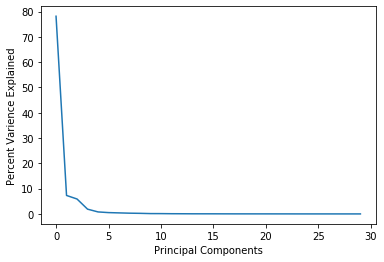

In [195]:
%matplotlib inline
ndim = 30
sc.tl.pca(post_adata,n_comps=ndim)
x = range(ndim)
y = 100*post_adata.uns['pca']['variance_ratio']
plt.plot(x,y)
plt.xlabel('Principal Components')
plt.ylabel('Percent Varience Explained')
plt.show()

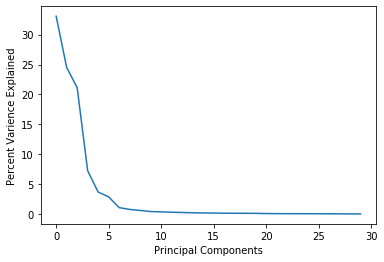

In [196]:
%matplotlib inline
ndim = 30
post_adata2 = anndata.AnnData(X=normalized_values)
sc.tl.pca(post_adata2,n_comps=ndim)
x = range(ndim)
y = 100*post_adata2.uns['pca']['variance_ratio']
plt.plot(x,y)
plt.xlabel('Principal Components')
plt.ylabel('Percent Varience Explained')
plt.show()

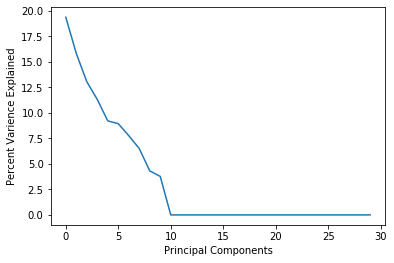

In [209]:
%matplotlib inline
ndim = 30
blank = np.zeros([latent.shape[0],20])
post_adata4 = anndata.AnnData(X=np.concatenate((latent,blank),axis=1))
sc.tl.pca(post_adata4,n_comps=ndim)
x = range(ndim)
y = 100*post_adata4.uns['pca']['variance_ratio']
plt.plot(x,y)
plt.xlabel('Principal Components')
plt.ylabel('Percent Varience Explained')
plt.show()

In [3]:
import pickle
pickle.load(open('/bigstore/GeneralStorage/Zach/CSI/metrics_0.pkl','rb'))

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [158]:
brain_size = 10**15 #um3
image_rate = 0.100 #s
npixels = 2048**2 #npixels
high_mag_hybes = 100
low_mag_hybes = 20
high_mag_pixel_size = 0.1**2 #um2 63X
low_mag_pixel_size = 0.3**2 #um2 20X
high_mag_step_size = 0.4 #um
low_mag_step_size = 5 #um
high_volume_per_image = npixels*high_mag_pixel_size*high_mag_step_size#um3
low_volume_per_image = npixels*low_mag_pixel_size*low_mag_step_size #um3
high_image_rate = high_volume_per_image/image_rate #um3/s
low_image_rate = low_volume_per_image/image_rate #um3/s
print('1E'+str(round(np.log10(high_mag_hybes*brain_size/high_image_rate),1))+'s 63X')#s
print('1E'+str(round(np.log10(low_mag_hybes*brain_size/low_image_rate),1))+'s 20X')#s

1E11.8s 63X
1E8.4s 20X


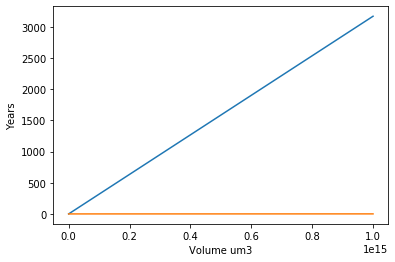

In [162]:
factor = (60*60*24*365)
Hrate = factor*(10**15)/(10**11) #um3/s
Lrate = factor*(10**15)/(2*10**7) #um3/s
Volume = 10**np.linspace(0,15)
H = Volume/Hrate
L = Volume/Lrate
Htime = (10**15)/Hrate
Ltime = (10**15)/Lrate
# plt.plot(np.log10(Volume),np.log10(H))
# plt.plot(np.log10(Volume),np.log10(L))
# plt.plot([0,15],[np.log10(Htime),np.log10(Htime)])
# plt.plot([0,15],[np.log10(Ltime),np.log10(Ltime)])
# plt.plot([15,15],[np.log10(np.min(L)),np.log10(np.max(Htime))])
# plt.ylim([0,5])
# plt.xlim([0,3])
plt.show()
plt.plot(Volume,H)
plt.plot(Volume,L)
# plt.plot([15,15],[np.min(L),np.max(Htime)])
# plt.plot([0,15],[Htime,Htime])
# plt.plot([0,15],[Ltime,Ltime])
plt.xlabel('Volume um3')
plt.ylabel('Years')
plt.show()

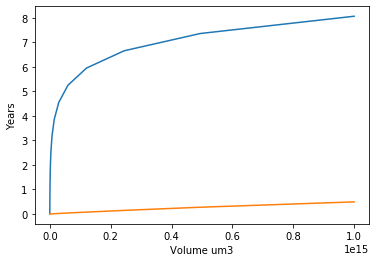

In [166]:
plt.plot(Volume,np.log(H+1))
plt.plot(Volume,np.log(L+1))
# plt.plot([15,15],[np.min(L),np.max(Htime)])
# plt.plot([0,15],[Htime,Htime])
# plt.plot([0,15],[Ltime,Ltime])
plt.xlabel('Volume um3')
plt.ylabel('Years')
plt.show()

In [163]:
np.max(L)

0.6341958396752917

In [91]:
np.log10(high_volume_per_image)

4.224719895935549

In [93]:
np.log10((2048*0.1)*(2048*0.1)*0.4)

4.224719895935549

In [94]:
np.log10((2048*0.6)*(2048*0.6)*5)

6.877932409710892

In [ ]:
# dendogram
sc.tl.dendrogram(adata, groupby='bulk_labels')
sc.pl.dendrogram(adata)